In [1]:
import pickle
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import numpy as np
from glob import glob
from copy import deepcopy
from msmbuilder.cluster import NDGrid
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pa

In [10]:
clusters = np.logspace(np.log10(10), np.log10(500), 5).astype(int)
frac_min, frac_max = 0.005, 1
fractions = [x for x in np.logspace(np.log10(frac_min), np.log10(frac_max), 5)]
result_dirs = ['../data/{:05.1f}pc'.format(x*100) for x in fractions]
processes = [0,1,2]
k = len(processes)
nsamples = 500
tau = 25
print(result_dirs)
print(clusters)
print(k)
print(nsamples)
print(tau)

['../data/000.5pc', '../data/001.9pc', '../data/007.1pc', '../data/026.6pc', '../data/100.0pc']
[ 10  26  70 188 499]
3
500
25


In [16]:
models = {}
for i, data_dir in enumerate(result_dirs):
    traj_paths = glob(data_dir+'/*.npy')
    X = [np.load(x) for x in traj_paths]
    for clust in clusters:
        label = '{0:04.3f}_{1}'.format(fractions[i], clust)
        cluster = NDGrid(max=1.2, min=-1.2, n_bins_per_feature=clust)
        ctrajs = cluster.fit_transform(X)
        mm = msm.BayesianMSM(lag=25, nsamples=nsamples)
        models[label] = mm.fit(ctrajs)

In [23]:
models

{'0.005_10': BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
       dt_traj='1 step', lag=25, nsamples=500, nsteps=3, reversible=True,
       show_progress=True, sparse=False, statdist_constraint=None),
 '0.005_188': BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
       dt_traj='1 step', lag=25, nsamples=500, nsteps=12, reversible=True,
       show_progress=True, sparse=False, statdist_constraint=None),
 '0.005_26': BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
       dt_traj='1 step', lag=25, nsamples=500, nsteps=5, reversible=True,
       show_progress=True, sparse=False, statdist_constraint=None),
 '0.005_499': BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
       dt_traj='1 step', lag=25, nsamples=500, nsteps=20, reversible=True,
       show_progress=True, sparse=False, statdist_constraint=None),
 '0.005_70': BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
       d

AttributeError: Can't pickle local object 'wrap.<locals>.null_wrapper'

In [25]:
data = {'clusters': [], 'process': [], 'timescale': [], 'data_fraction':[]}
nprocesses = 3
for k, v in models.items():
    print(k)
    
    allts  = v.sample_f('timescales', k=3)
    allts = np.vstack(allts)
    nclusters = int(k.split('_')[-1])
    data_fraction = k.split('_')[0]
    
    data['clusters'].extend([nclusters]*nsamples*nprocesses)
    data['data_fraction'].extend([data_fraction]*nsamples*nprocesses)
    for proc in processes:
        data['process'].extend([proc+2]*nsamples)
        data['timescale'].extend(allts[:, proc])
        
        

0.071_188
0.266_188
1.000_10
0.071_10
0.266_70
1.000_70
1.000_499
0.019_10
1.000_188
0.019_499
1.000_26
0.071_499
0.005_188
0.005_10
0.005_499
0.019_188
0.019_70
0.071_70
0.005_70
0.266_499
0.071_26
0.266_26
0.266_10
0.019_26
0.005_26


In [26]:
df = pd.DataFrame(data)

In [27]:
df.to_pickle('hmm_vs_discretization.pickl')


In [2]:
df = pd.read_pickle('hmm_vs_discretization.pickl')
df['t2_fraction'] = df['data_fraction'].apply(lambda x: '{:05.2f}t2'.format(float(x)*10))

In [3]:
exact_timescales = [844.4, 125.5, 64.3]

In [4]:
t2_fracs = df['t2_fraction'].unique()
t2_fracs.sort()
t2_fracs

array(['00.05t2', '00.19t2', '00.71t2', '02.66t2', '10.00t2'], dtype=object)

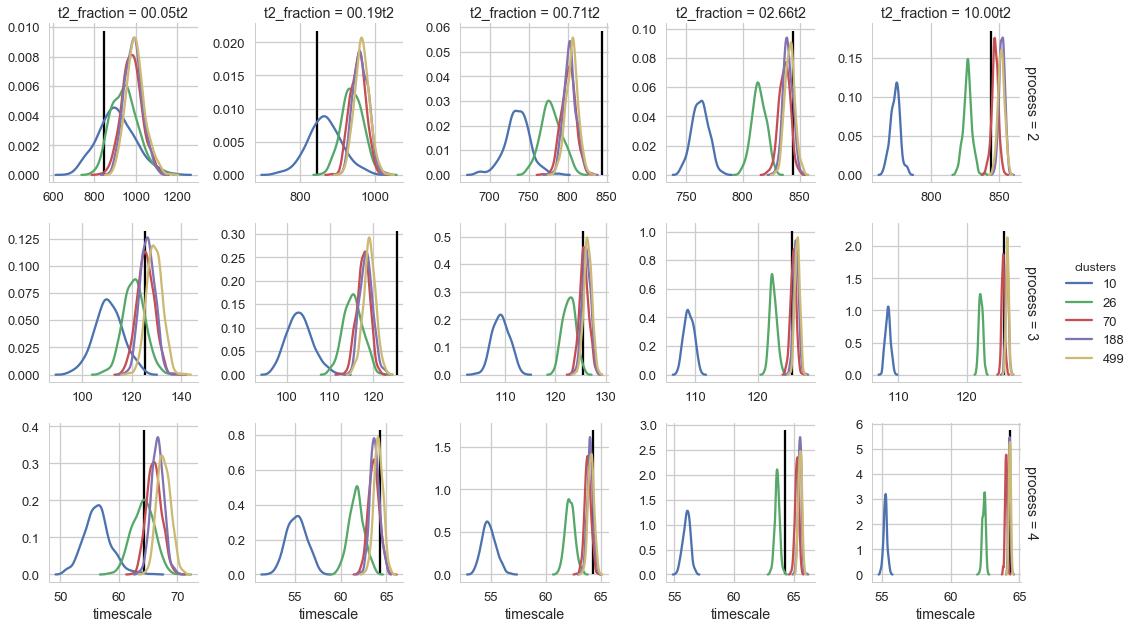

In [5]:
with sns.plotting_context('talk', font_scale=1):
    sns.set_style('whitegrid')
    g = sns.FacetGrid(hue='clusters', row='process',col='t2_fraction',col_order=t2_fracs, 
                      data=df, sharex=False, sharey=False, 
                     margin_titles=True)
    g.map(sns.distplot, 'timescale', hist=False).add_legend()
    for i in  range(g.axes.shape[0]):
        for j in range(g.axes.shape[1]):
            ax = g.axes[i][j]
            ax.vlines(exact_timescales[i], 0, ax.get_ylim()[1])
        
    plt.savefig('../figures/cluster_vs_timescale_dist.png', transparent=True)
    